# Protein Analysis and Clustering

This notebook demonstrates how to compute protein features from amino acid sequences using Biopython, then cluster proteins based on these features. The approach is analogous to the glycan analysis you described, but here we work with sequence-based descriptors.

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform

# Ensure inline plots
%matplotlib inline

proteins = pd.read_csv('../data/Protein-Sequence-Table.txt', sep='\t')
proteins.head()

,ProteinGroup,Accession,Uniprot,Description,Amino Acid Sequence
0,1,Q41358,SNAIB_SAMNI,Ribosome-inactivating protein SNAI,MRLVAKLLYLAVLAICGLGIHGALTHPRVTPPVYPSVSFNLTGADT...
1,2,P22972,LEC1_ULEEU,Anti-H(O) lectin 1,SDDLSFKFKNFSQNGKDLSFQGDASVIETGVLQLNKVGNNLPDETG...
2,4,A8WDZ4,A8WDZ4_CANEN,Concanavalin A,MAISKKSSLFLPIFTFITMFLMVVNKVSSSTHETNALHFMFNQFSK...
3,6,P09382,LEG1_HUMAN,Galectin-1,MACGLVASNLNLKPGECLRVRGEVAPDAKSFVLNLGKDSNNLCLHF...
4,7,P16045,LEG1_MOUSE,Galectin-1,MACGLVASNLNLKPGECLKVRGEVASDAKSFVLNLGKDSNNLCLHF...


### Glycan–Protein Interaction Feature Extraction

This function extracts features that capture key dimensions of protein sequences relevant to glycan binding. It includes:

- **Overall size and stability**: Length, molecular weight, and instability index.  
- **Charge properties**: Isoelectric point and net charge at pH 7, essential for electrostatic interactions with charged glycans.  
- **Polar/hydrogen-bonding residues**: Fractions of N, Q, S, T, K, R, D, E—critical for forming hydrogen bonds with sugar groups.  
- **Aromatic residues**: Fractions of F, Y, W, plus an aromatic binding score that sums these fractions, reflecting the potential for CH–π interactions.  
- **Hydrophobicity**: An average Kyte-Doolittle score to show how hydrophobic or hydrophilic the sequence is overall.

Together, these features capture multiple facets—charge, polar binding potential, aromatic stacking ability, and structural characteristics—giving us a broad view of each protein’s capacity for glycan interaction.

In [110]:
def compute_protein_features(seq):
    # Protein Analysis is a Tool from Biopython
    analysis = ProteinAnalysis(seq)
    features = {}
    
    # The following are Basic Features
    features['length'] = len(seq)
    features['mw'] = analysis.molecular_weight()
    features['aromaticity'] = analysis.aromaticity()
    features['instability_index'] = analysis.instability_index()

    features['net_charge_pH7'] = analysis.charge_at_pH(7.0)

    aa_percent = analysis.get_amino_acids_percent()
    
    for aa in ['N', 'Q', 'S', 'T', 'K', 'R', 'D', 'E']:
        features[f'frac_{aa}'] = aa_percent.get(aa, 0.0)

   
    for aa in ['F', 'Y', 'W']:
        features[f'frac_{aa}'] = aa_percent.get(aa, 0.0)
        features['aromatic_binding_score'] = (
        aa_percent.get('F', 0.0) +
        aa_percent.get('Y', 0.0) +
        aa_percent.get('W', 0.0)
    )

    features['aromaticity'] = analysis.aromaticity()

    hydrophobicity_values = {
        'A': 1.8,  'C': 2.5,  'D': -3.5, 'E': -3.5,
        'F': 2.8,  'G': -0.4, 'H': -3.2, 'I': 4.5,
        'K': -3.9, 'L': 3.8,  'M': 1.9,  'N': -3.5,
        'P': -1.6, 'Q': -3.5, 'R': -4.5, 'S': -0.8,
        'T': -0.7, 'V': 4.2,  'W': -0.9, 'Y': -1.3
    }
    if len(seq) > 0:
        hydro_scores = [hydrophobicity_values.get(res, 0.0) for res in seq]
        features['avg_hydrophobicity'] = np.mean(hydro_scores)
    else:
        features['avg_hydrophobicity'] = 0.0

    return features

feature_dicts = proteins['Amino Acid Sequence'].apply(compute_protein_features)
features_df = pd.DataFrame(list(feature_dicts))

proteins = pd.concat([proteins, features_df], axis=1)

# Display the updated dataframe
proteins.head()

/opt/miniconda3/envs/glycan-env/lib/python3.13/site-packages/Bio/SeqUtils/ProtParam.py:106: BiopythonDeprecationWarning: The get_amino_acids_percent method has been deprecated and will likely be removed from Biopython in the near future. Please use the amino_acids_percent attribute instead.
  warnings.warn(


,ProteinGroup,Accession,Uniprot,Description,Amino Acid Sequence,length,mw,aromaticity,instability_index,isoelectric_point,...,aa_P,aa_Q,aa_R,aa_S,aa_T,aa_V,aa_W,aa_Y,aromatic_binding_score,avg_hydrophobicity
0,1,Q41358,SNAIB_SAMNI,Ribosome-inactivating protein SNAI,MRLVAKLLYLAVLAICGLGIHGALTHPRVTPPVYPSVSFNLTGADT...,570,63100.9796,0.085965,30.327544,5.523920,...,0.049123,0.040351,0.057895,0.075439,0.077193,0.092982,0.017544,0.033333,0.085965,-0.069298
1,2,P22972,LEC1_ULEEU,Anti-H(O) lectin 1,SDDLSFKFKNFSQNGKDLSFQGDASVIETGVLQLNKVGNNLPDETG...,243,26669.1822,0.119342,33.731687,4.633765,...,0.045267,0.024691,0.028807,0.102881,0.078189,0.065844,0.016461,0.032922,0.119342,-0.239095
2,4,A8WDZ4,A8WDZ4_CANEN,Concanavalin A,MAISKKSSLFLPIFTFITMFLMVVNKVSSSTHETNALHFMFNQFSK...,290,31480.0500,0.096552,31.053483,5.469298,...,0.044828,0.017241,0.024138,0.127586,0.082759,0.079310,0.013793,0.027586,0.096552,-0.020690
3,6,P09382,LEG1_HUMAN,Galectin-1,MACGLVASNLNLKPGECLRVRGEVAPDAKSFVLNLGKDSNNLCLHF...,135,14715.5455,0.096296,24.134815,5.334987,...,0.051852,0.022222,0.037037,0.037037,0.029630,0.074074,0.007407,0.014815,0.096296,-0.151111
4,7,P16045,LEG1_MOUSE,Galectin-1,MACGLVASNLNLKPGECLKVRGEVASDAKSFVLNLGKDSNNLCLHF...,135,14865.6989,0.088889,20.876296,5.320096,...,0.051852,0.014815,0.029630,0.037037,0.051852,0.051852,0.007407,0.007407,0.088889,-0.264444


## Clustering Proteins Based on Features

Using the computed features, we calculate a pairwise Euclidean distance matrix and apply KMeans clustering to group similar proteins together. This step will help us later perform train/test splits that respect protein similarity.

In [111]:
# Select the feature columns (all columns from the feature extraction)
feature_columns = features_df.columns.tolist()
feature_data = proteins[feature_columns].values

# comput dist
dist_matrix = squareform(pdist(feature_data, metric='euclidean'))

# apply k means clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
proteins['cluster_label'] = kmeans.fit_predict(feature_data)

# Show cluster counts
print(proteins['cluster_label'].value_counts())

cluster_label
1    26
0    21
2     5
Name: count, dtype: int64


## Visualize Clusters with PCA

We use PCA to reduce the feature space to 2 dimensions for visualization. This helps in understanding how the proteins are grouped based on the computed descriptors.

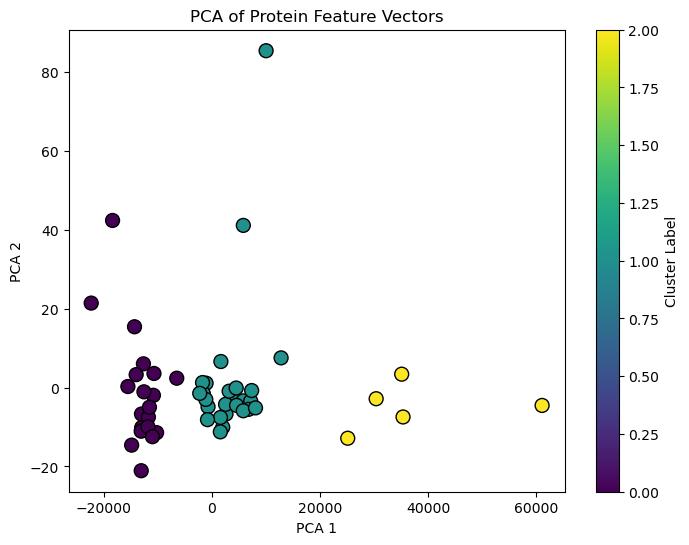

In [112]:
# Perform PCA to reduce the feature dimensionality
pca = PCA(n_components=2)
pca_components = pca.fit_transform(feature_data)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(pca_components[:, 0], pca_components[:, 1], 
                      c=proteins['cluster_label'], cmap='viridis', s=100, edgecolor='k')
plt.title('PCA of Protein Feature Vectors')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

- Assign entire clusters to either train or test
- Ensure proteins that are similar remain in the same cluster

In [113]:
unique_clusters = proteins['cluster_label'].unique()
np.random.seed(42)
np.random.shuffle(unique_clusters)

test_fraction = 0.01
n_test_clusters = max(1, int(len(unique_clusters) * test_fraction))
test_clusters = unique_clusters[:n_test_clusters]
train_clusters = unique_clusters[n_test_clusters:]

print(f"Test clusters: {test_clusters}")
print(f"Train clusters: {train_clusters}")

train_set = proteins[proteins['cluster_label'].isin(train_clusters)].copy()
test_set = proteins[proteins['cluster_label'].isin(test_clusters)].copy()

print(f"Train set size: {len(train_set)}")
print(f"Test set size: {len(test_set)}")

Test clusters: [2]
Train clusters: [1 0]
Train set size: 47
Test set size: 5


---
End of Notebook